## Задача прогнозирования температуры

Во всех наших примерах в этом разделе мы будем играть с погодой
набором  временных рядов, записанных на метеостанции в Институте биогеохимии им. Макса Планка в Йене, Германия: http://www.bgc-jena.mpg.de/wetter/.

В этом наборе данных записано четырнадцать различных величин (таких как температура воздуха, атмосферное давление, влажность, направление ветра и т. Д.)
каждые десять минут, в течение нескольких лет. Исходные данные относятся к 2003 году, но мы ограничиваемся данными за 2009-2016 годы. Этот набор данных
идеально подходит для обучения работе с числовыми временными рядами. Мы будем использовать его для построения модели, которая принимает в качестве входных данных некоторые данные из недавнего прошлого (
несколько дней стоит данных) и прогнозирует температуру воздуха на 24 часа в будущем.


Посмотрим на данные!

In [1]:
import os


fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


переведем все в numpy array

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

нарисуем график температуры

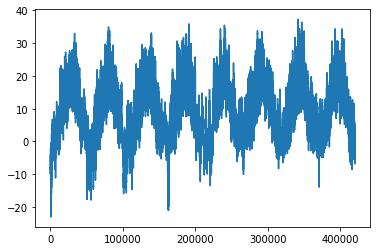

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # температура
plt.plot(range(len(temp)), temp)
plt.show()

На этом графике вы можете четко увидеть годовую периодичность температуры.

Вот более узкий график данных о температуре за первые десять дней (поскольку данные записываются каждые десять минут, мы получаем 144 точки данных
в день):

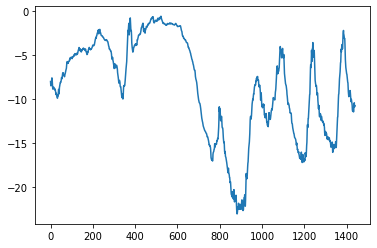

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

На этом графике вы можете увидеть ежедневную периодичность, особенно заметную за последние 4 дня. Мы также можем отметить, что этот десятидневный период должен быть
взят из довольно холодного зимнего месяца.

Если бы мы пытались предсказать среднюю температуру для следующего месяца, учитывая данные за несколько месяцев, проблема была бы легкой из-за
достоверной годовой периодичности данных. Но, глядя на данные в масштабе дней, температура выглядит намного более хаотичной. 


## Подготовка данных


Точная формулировка нашей проблемы будет следующей: данные возвращаются к временным шагам `lookback` (временной шаг 10 минут)
и выборка каждые `шаги` временные шаги, мы можем предсказать температуру в `через` несколько временных сдвигов?

Мы будем использовать следующие значения параметров:

* `lookback = 720`, то есть наши наблюдения вернутся на 5 дней назад.
* `steps = 6`, т.е. наши наблюдения будут отбираться в одной точке данных в час.
* `delay = 144`, то есть наш таргет в будущем будет через 24 часа.

Для начала нам нужно сделать две вещи:

* Предварительная обработка данных до формата, который нейронная сеть может принять. Это легко: данные уже числовые, поэтому нам не нужно делать никаких
векторизации. Однако каждый временной ряд в данных имеет разный масштаб (например, температура обычно составляет от -20 до +30, но
давление, измеренное в мбар, составляет около 1000). Поэтому мы будем всё нормализовывать
* Напишем наш генератор Python, который берет наш текущий массив данных  и выдает батчи данных из недавнего прошлого вместе с
целевой температурой в будущем. Поскольку выборки в нашем наборе данных сильно избыточны (например, выборка `N` и выборка` N + 1` будут иметь большинство
их общих временных шагов) было бы очень расточительно явно распределять каждую выборку. Вместо этого мы будем генерировать образцы на
летать, используя оригинальные данные.

Мы предварительно обрабатываем данные путем вычитания среднего значения каждой временной серии и деления на стандартное отклонение. Мы планируем использовать первый
200 000 временных шагов в качестве обучающих данных, поэтому мы вычисляем среднее и стандартное отклонение только для этой части данных:

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Теперь вот генератор данных, который мы будем использовать. Он даст кортеж `(samples, target)`, где `samples` - одна партия входных данных и
`target` - соответствующий массив целевых температур. Требуются следующие аргументы:

* `data`: исходный массив данных с плавающей запятой, который мы только что нормализовали в приведенном выше фрагменте кода.
* `lookback`: Сколько временных шагов назад должны пройти наши входные данные.
* `delay`: через сколько шагов прогнозим
* `min_index` и` max_index`: индексы в массиве `data`, которые разграничивают временные шаги для отрисовки. 
* `shuffle`: перетасовать наши батчи или нарисовать их в хронологическом порядке.
* `batch_size`: количество данных на батч.
* `step`: период в временных шагах, с каким мы производим выборку данных. Мы установим его на 6, чтобы рисовать одну точку данных каждый час.

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Теперь давайте использовать нашу функцию абстрактного генератора для создания трех генераторов, одного для обучения, одного для проверки и одного для тестирования.


In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# сколько рисовать точек для валидации
val_steps = (300000 - 200001 - lookback) // batch_size


test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
for train_step_s1, target_s1 in train_gen:
    break

In [9]:
train_step_s1.shape

(128, 240, 14)

In [10]:
target_s1.shape

(128,)

## Здравый смысл, бейзлайн



В нашем случае температурные временные ряды можно смело считать периодическими (завтра температура, вероятно, будет близка к
температура сегодня). Таким образом, подход здравого смысла будет всегда предсказывать, что температура через
24 часа будут равны температуре прямо сейчас. Давайте оценим этот подход, используя метрику средней абсолютной ошибки (MAE).


In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## Первая реккурентная сетка




#### Чуть общего знания

`SimpleRNN` - ячейка (как и любая другая рекурентная ячейка) может работать в двух разных режимах: она может возвращать либо полные последовательности, либо последний спрогнозированный член. За это отвечает аргумент `return_sequence`. Давайте посмотрим на пример:

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [13]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Dense(60))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
dense (Dense)                (None, None, 60)          1980      
Total params: 324,060
Trainable params: 324,060
Non-trainable params: 0
_________________________________________________________________


In [14]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # Последний выход должен выводить только последний результат
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 169s - loss: 0.3216 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 168s - loss: 0.2846 - val_loss: 0.2654
Epoch 3/20
500/500 [==============================] - 168s - loss: 0.2772 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 168s - loss: 0.2707 - val_loss: 0.2663
Epoch 5/20
500/500 [==============================] - 168s - loss: 0.2643 - val_loss: 0.2680
Epoch 6/20
500/500 [==============================] - 169s - loss: 0.2584 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 168s - loss: 0.2553 - val_loss: 0.2658
Epoch 8/20
500/500 [==============================] - 168s - loss: 0.2508 - val_loss: 0.2672
Epoch 9/20
500/500 [==============================] - 165s - loss: 0.2455 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 164s - loss: 0.2423 - val_loss: 0.2801
Epoch 11/20
500/500 [==============================] - 164s - loss: 0

Рисуем!

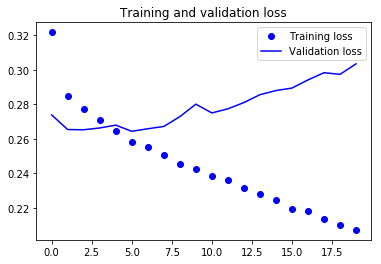

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Использование dropout для борьбы с переобучением




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 171s - loss: 0.3526 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 170s - loss: 0.3138 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 170s - loss: 0.3033 - val_loss: 0.2694
Epoch 5/40
500/500 [==============================] - 170s - loss: 0.3006 - val_loss: 0.2695
Epoch 6/40
500/500 [==============================] - 170s - loss: 0.2990 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 170s - loss: 0.2955 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 170s - loss: 0.2942 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 171s - loss: 0.2940 - val_loss: 0.2649
Epoch 10/40
500/500 [==============================] - 170s - loss: 0.2923 - val_loss: 0.2673
Epoch 11/40
500/500 [==============================] - 170s - loss: 0

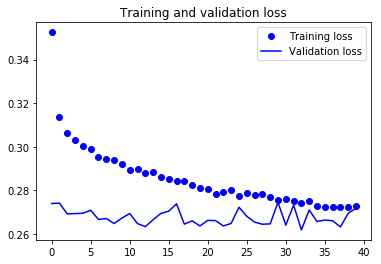

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Мы не переобучаемся на первых эпохах, но наши оценки все еще не лучше предыдущих результатов

## Stacking recurrent layers



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

## давайте соберем двухслойную сетку
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

Рисуем!

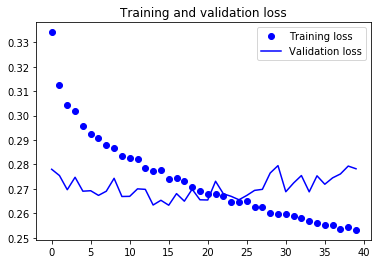

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()